Task 1

We can train an RNN model to predict the next character given a sequence of characters. Such models are affectionately known as Char-RNNs.

Train a Char-RNN model on the Tiny Shakespeare dataset. You can use the following repositories as a reference:

• Char-RNN in PyTorch: https://github.com/spro/char-rnn.pytorch

• Char-RNN in Tensorflow: https://github.com/karpathy/char-rnn

Report the change in perplexity during training. Plot a graph to do so. Smoothen the curve if required. Plots that are not readable or are not self explanatory will not be considered.

In [18]:
pip install tqdm


Note: you may need to restart the kernel to use updated packages.


In [19]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import argparse
import os
import unidecode
import string
import random
import time
import math

from tqdm import tqdm

In [22]:
class Args():
    def __init__(self):
        self.filename = 'filename'
        self.model = "gru"
        self.n_epochs = 500
        self.print_every = 100
        self.hidden_size = 100
        self.n_layers = 2
        self.learning_rate = 0.01
        self.chunk_len = 200
        self.batch_size = 100
        self.shuffle = True
        self.cuda = False

args = Args()
args.filename = 'shakespeare.txt'
#An instance of the Args class is created = args. The filename attribute is then modified to 'shakespeare.txt'.

if torch.cuda.is_available():
    args.cuda = True

if args.cuda:
    print("Using CUDA")
    
#If CUDA is enabled (args.cuda == True), the message "Using CUDA" is printed.
    
#The Args class defines a set of default configuration parameters for the model. It initializes several attributes such as filename ...


In [26]:
#MODEL

class CharRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, model="gru", n_layers=1):
        super(CharRNN, self).__init__()
        self.model = model.lower()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers

        self.encoder = nn.Embedding(input_size, hidden_size)
        if self.model == "gru":
            self.rnn = nn.GRU(hidden_size, hidden_size, n_layers)
        elif self.model == "lstm":
            self.rnn = nn.LSTM(hidden_size, hidden_size, n_layers)
        self.decoder = nn.Linear(hidden_size, output_size)

    def forward(self, input, hidden):
        batch_size = input.size(0)
        encoded = self.encoder(input)
        output, hidden = self.rnn(encoded.view(1, batch_size, -1), hidden)
        output = self.decoder(output.view(batch_size, -1))
        return output, hidden

    def forward2(self, input, hidden):
        encoded = self.encoder(input.view(1, -1))
        output, hidden = self.rnn(encoded.view(1, 1, -1), hidden)
        output = self.decoder(output.view(1, -1))
        return output, hidden
        
    def init_hidden(self, batch_size):
        if self.model == "lstm":
            return (Variable(torch.zeros(self.n_layers, batch_size, self.hidden_size)),
                    Variable(torch.zeros(self.n_layers, batch_size, self.hidden_size)))
        return Variable(torch.zeros(self.n_layers, batch_size, self.hidden_size))

    

In [32]:
import unidecode
import string
import random
import time
import math
import torch

# Reading and un-unicode-encoding data

all_characters = string.printable
n_characters = len(all_characters)

def read_file(filename):
    file = unidecode.unidecode(open(filename).read())
    return file, len(file)

file, file_len = read_file(args.filename)
# Turning a string into a tensor where each character in the string is represented as an index into the all_characters string. 

def char_tensor(string):
    tensor = torch.zeros(len(string)).long()
    for c in range(len(string)):
        try:
            tensor[c] = all_characters.index(string[c])
        except:
            continue
    return tensor

# Readable time elapsed

def time_since(since):
    s = time.time() - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


In [45]:
def generate(decoder, prime_str='A', predict_len=100, temperature=0.8, cuda=False, tensor_fn=char_tensor, chars=all_characters, word = False):
    predicted = prime_str
#The temperature parameter controls the randomness of the sampling process.Lower values of temperature result in more predictable output 
    if word:
      prime_str = prime_str.split()
      #print(prime_str)

    hidden = decoder.init_hidden(1)
    prime_input = Variable(tensor_fn(prime_str).unsqueeze(0))

    if cuda:
        hidden = hidden.cuda()
        prime_input = prime_input.cuda()

    # Use priming string to "build up" hidden state
    for p in range(len(prime_str) - 1):
        _, hidden = decoder(prime_input[:,p], hidden)
        
    inp = prime_input[:,-1]
    
    for p in range(predict_len):
        output, hidden = decoder(inp, hidden)
        
        # Sample from the network as a multinomial distribution
        output_dist = output.data.view(-1).div(temperature).exp()
        top_i = torch.multinomial(output_dist, 1)[0]

        # Add predicted character to string and use as next input
        predicted_char = all_characters[top_i]
        predicted += predicted_char
        inp = Variable(char_tensor(predicted_char).unsqueeze(0))
        if cuda:
            inp = inp.to(device)

    return predicted


In [38]:
#training
from ctypes import c_char_p
def random_training_set(args, file=file, file_len=file_len, tensor_fn=char_tensor):
    inp = torch.LongTensor(args.batch_size, args.chunk_len)
    target = torch.LongTensor(args.batch_size, args.chunk_len)
    for bi in range(args.batch_size):
        start_index = random.randint(0, file_len - args.chunk_len - 1)
        end_index = start_index + args.chunk_len + 1
        chunk = file[start_index:end_index]
        inp[bi] = tensor_fn(chunk[:-1])
        target[bi] = tensor_fn(chunk[1:])
    inp = Variable(inp)
    target = Variable(target)
    if args.cuda:
        inp = inp.cuda()
        target = target.cuda()
    return inp, target

# training of the model on a single batch of data. 
#The loss is computed for each character and the gradients are backpropagated through time.

def train(args, inp, target, decoder, criterion, decoder_optimizer):
    hidden = decoder.init_hidden(args.batch_size)
    if args.cuda:
        hidden = hidden.cuda()
    decoder.zero_grad()
    loss = 0

    for c in range(args.chunk_len):
        output, hidden = decoder(inp[:,c], hidden)
        loss += criterion(output.view(args.batch_size, -1), target[:,c])

    loss.backward()
    decoder_optimizer.step()

    return loss.item() / args.chunk_len

def save(args, decoder, save_filename):
    save_filename = save_filename + '.pt'
    torch.save(decoder, save_filename)
    print('Saved as %s' % save_filename)
    

# Initialize models and start training

decoder = CharRNN(
    n_characters,
    args.hidden_size,
    n_characters,
    model=args.model,
    n_layers=args.n_layers,
)
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=args.learning_rate)
criterion = nn.CrossEntropyLoss()

if args.cuda:
    decoder.cuda()

start = time.time()
all_losses = []
loss_avg = 0

args.chunk_len = 200

try:
    print("Training for %d epochs..." % args.n_epochs)
    for epoch in tqdm(range(1, args.n_epochs + 1)):
    #for epoch in tqdm(range(1, 2)):
        loss = train(args, *random_training_set(args, file, file_len, tensor_fn=char_tensor), decoder, criterion, decoder_optimizer)
        loss_avg += loss
        all_losses.append(math.exp(loss))

        if epoch % args.print_every == 0:
            print('[%s (%d %d%%) %.4f]' % (time_since(start), epoch, epoch / args.n_epochs * 100, loss))
            print(generate(decoder, 'Wh', 100, cuda=args.cuda), '\n')

    print("Saving...")
    save(args, decoder, "shakespeare")

except KeyboardInterrupt:
    print("Saving before quit...")
    save(args, decoder, "shakespeare")

Training for 500 epochs...


 20%|██        | 100/500 [02:06<08:35,  1.29s/it]

 6s (100 20%) 1.7867]
Where chead for not frown, whilence ferfieR
The hast
Frither shall word me that be for the manent no p 



 40%|████      | 200/500 [04:19<07:11,  1.44s/it]

 19s (200 40%) 1.5540]
Which a fair at thou onon;
And what, which he have their father'd
What do can dread like of the king m 



 60%|██████    | 300/500 [06:34<04:35,  1.38s/it]

 33s (300 60%) 1.5264]
Where is thy lord in thee to with your dull forget
Face do thy chast you upon the read
you deserved's  



 80%|████████  | 400/500 [08:52<02:17,  1.38s/it]

 52s (400 80%) 1.4393]
Whild the die, sir: but as I though I will her need.

LEONTES:
Has under be made, kills the king been  



100%|██████████| 500/500 [11:11<00:00,  1.34s/it]

 11s (500 100%) 1.4331]
Whill not; but you will I am the Jurether; but senate
Their house and been till 'tis man, I them had n 

Saving...
Saved as shakespeare.pt



C:\Users\olfia\anaconda3\envs\env_pytorch\lib\site-packages\torch\serialization.py:256: UserWarning: Couldn't retrieve source code for container of type CharRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


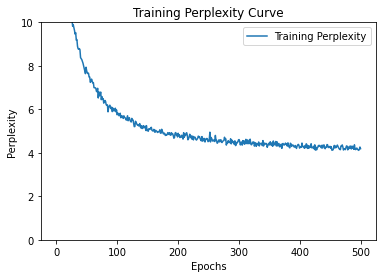

In [40]:
import matplotlib.pyplot as plt

epochs = len(all_losses)
plt.plot(range(epochs), all_losses, label='Training Perplexity')
plt.title('Training Perplexity Curve')
plt.xlabel('Epochs')
plt.ylabel('Perplexity')
plt.ylim(0, 10)

# set the legend and display the plot
plt.legend()
plt.show()

Task 2 



Use the trained Char-Rnn model from Task 1 and report 3 generated sequences of length 100 by
priming the model with random character sequences of length 5. E.g., "2 b3n", "bg09Z", etc.
While reporting the generated sequences, also report their corresponding priming sequences.

In [46]:

decoder = torch.load('shakespeare.pt')
print(generate(decoder, prime_str='hj34s', cuda=args.cuda, tensor_fn=char_tensor, chars=all_characters))

hj34s like betterfeit you,
And then the sead to past hate me other in me?

WARWICK:
Why close you, sir, I


In [47]:
print(generate(decoder, prime_str='2sf 4', cuda=args.cuda, tensor_fn=char_tensor, chars=all_characters))

2sf 4range to crusis.

First Master:
Alate one srather, 'tis twenty lord.

ANTONIO:
Where is yet you.

CA


In [48]:
print(generate(decoder, prime_str='  3  ', cuda=args.cuda, tensor_fn=char_tensor, chars=all_characters))

  3  LENTIO:
Let the revieck'd; and thus last his clows. Where,
Their bring it on all make me go talk
The


Task 3 


Like in the previous task, generate character sequences of length 100 for the following priming
sequences:
• The
• What is
• Shall I give
• X087hNYB BHN BYFVuhsdbs

In [49]:
print(generate(decoder, prime_str='The', cuda=args.cuda, tensor_fn=char_tensor, chars=all_characters))

Ther and couns any sulipition.

LEONTES:
Benes,
Wither's sentleman's discourph not affecting; to the ey


In [50]:
print(generate(decoder, prime_str='What is', cuda=args.cuda, tensor_fn=char_tensor, chars=all_characters))

What is my care of York of the Frand:
The Prove a sweet seen hard of reseetish'd the mifstors
And she in th


In [51]:
print(generate(decoder, prime_str='Shall I give', cuda=args.cuda, tensor_fn=char_tensor, chars=all_characters))

Shall I give must once? is my lord:
I have done the morning them.

ANGELO:
Is not soul ship to me should king?




In [52]:
print(generate(decoder, prime_str='X087hNYB BHN BYFVuhsdbs', cuda=args.cuda, tensor_fn=char_tensor, chars=all_characters))

X087hNYB BHN BYFVuhsdbs cheeks often great further.

GLOUCESTER:
But you have you will be with you, sease:
Let me them betw


Neural Language Models (OPTIONAL)

1) What are Language Models? Where and how are Language Models used?

Language Models (LMs) are computational models that are used to predict the probability of occurrence of a given sequence of words in a language. These models are trained on large datasets of text and are capable of predicting the likelihood of the next word in a sequence given the previous words.

Language Models are used in various applications such as speech recognition, machine translation, text-to-speech synthesis, and automatic summarization.

For example, language models are used in chatbots to generate responses to user queries. + in search engines to accurately predict the user’s next search query based on their previous searches.

2) How can you use a trained Char-RNN model as a Character Level Language Model? 
A trained Char-RNN model can be used as a Character Level Language Model by inputting a sequence of characters and using the model to generate the probability distribution of the next character in the sequence. This can be achieved by passing the current sequence of characters through the model and using the output of the last layer to predict the probability distribution of the next character.

Once the probability distribution is generated, the next character can be sampled from the distribution either deterministically by selecting the character with the highest probability or stochastically by sampling from the distribution according to the corresponding probabilities. By repeating this process, a new sequence of characters can be generated.

-> a powerful tool for generating new sequences of characters that can be used in various applications, such as text generation, language translation, and speech recognition.

3) How can you train a Word Level Language Model? 
- Collect a large corpus of text data and preprocess it to remove unwanted characters, numbers, and punctuation.

- Tokenize the text into words and create a vocabulary of all unique words present in the corpus.

- Split the corpus into training and validation sets.

- Convert the words into numerical representations using one-hot encoding or word embeddings.

- Design and build a neural network architecture for the language model, which can take in a sequence of word embeddings and predict the next word in the sequence.

- Train the language model on the training data, minimizing the loss function, and validate the model on the validation set.

- Tune the hyperparameters of the model

Once the model is trained, it can be used to generate new text by sampling from the output probabilities of the last layer of the model.

4) Formally describe the inference model that an RNN trained to predict the next word represents?

The language model takes in a sequence of words (w_1, w_2, ..., w_t), and its goal is to predict the probability distribution of the next word w_t+1.

The RNN-based language model uses the hidden state h_t as a summary of the sequence up to time step t, and this is updated after each new input. The hidden state at time t is a function of the current input word w_t, the previous hidden state h_t-1, and the network parameters, such as the weights and biases.

The conditional probability distribution of the next word w_t+1 given the previous words up to time step t, p(w_t+1|w_1, w_2, ..., w_t), can be estimated using the current hidden state h_t and the network parameters.

During inference, the RNN generates a sequence of words by iteratively predicting the probabilities of the next word and sampling from the distribution. This process continues until a predetermined stopping criteria is met, such as a predefined maximum sequence length, or a specific end-of-sequence token is generated.

Overall, an RNN trained to predict the next word represents a language model that estimates the probability distribution of the next word given the previous words, using a sequence summary of the inputs up to the current time step. 

5) How will you generate the "probability of existence" of an input sequence of words, given a trained RNN Language Model? 

We can use the trained RNN to generate the sequence of hidden states corresponding to each word in the input sequence. Then, for each time step, the output of the RNN can be passed through a softmax function to obtain the probability distribution over the vocabulary of possible next words.

For example, if we have an input sequence of words "The cat sat on the", we could pass the sequence through the trained RNN and compute the probability of each possible next word (e.g. "mat," "chair," "car"). We could then multiply these probabilities together to get the overall probability of the input sequence.

